In [11]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
data = pd.read_csv('./data/cleaned_data/heart_cleaned.csv')

In [13]:
X = data.drop(['HeartDisease'], axis=1).values  
y = data['HeartDisease'].values

In [14]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

plt.style.use('dark_background')

## Multi Layer Perceptron (MLP)

In [17]:
import optuna

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_layers, hidden_units, dropout_rate):
        super(MLP, self).__init__()
        layers = []
        for _ in range(hidden_layers):
            layers.append(nn.Linear(input_dim, hidden_units))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            input_dim = hidden_units
        layers.append(nn.Linear(hidden_units, 1))
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

def train_and_evaluate_model(trial):
 
    hidden_layers = trial.suggest_int("hidden_layers", 2, 5)   
    hidden_units = trial.suggest_int("hidden_units", 16, 48)   
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4)   
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)   
    batch_size = trial.suggest_int("batch_size", 26, 39, step=16)   

 
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

  
    input_dim = X_train.shape[1]
    model = MLP(input_dim, hidden_layers, hidden_units, dropout_rate)
    model = model.to("cpu")

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

 
    for epoch in range(100):   
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

 
    model.eval()
    y_val_pred = []
    with torch.no_grad():
        for inputs, _ in val_loader:
            outputs = model(inputs)
            y_val_pred.extend((outputs > 0.5).float().numpy())
    y_val_pred = np.array(y_val_pred).flatten()
    y_val_true = y_val.numpy().flatten()
    conf_matrix = confusion_matrix(y_val_true, y_val_pred)

 
    TP = conf_matrix[1][1]   
    TN = conf_matrix[0][0]   
    FP = conf_matrix[0][1]   
    FN = conf_matrix[1][0]  

    accuracy = (TP + TN) / (TP + 2 * FP + TN + 1e-6)

    return -accuracy

study = optuna.create_study(direction="minimize")
study.optimize(train_and_evaluate_model, n_trials=50)

best_params = study.best_trial.params
print("Best parameters:", best_params)

[I 2024-12-04 20:49:22,324] A new study created in memory with name: no-name-77958009-4733-40b3-a307-7d3e7efbd467
The distribution is specified by [26, 39] and step=16, but the range is not divisible by `step`. It will be replaced by [26, 26].
[I 2024-12-04 20:49:26,227] Trial 0 finished with value: -0.8757062097417728 and parameters: {'hidden_layers': 4, 'hidden_units': 24, 'dropout_rate': 0.314385798931496, 'lr': 0.00011845737759746006, 'batch_size': 26}. Best is trial 0 with value: -0.8757062097417728.
The distribution is specified by [26, 39] and step=16, but the range is not divisible by `step`. It will be replaced by [26, 26].
[I 2024-12-04 20:49:30,437] Trial 1 finished with value: -0.9222222170987655 and parameters: {'hidden_layers': 5, 'hidden_units': 26, 'dropout_rate': 0.22703686717838323, 'lr': 0.00044917417100999056, 'batch_size': 26}. Best is trial 1 with value: -0.9222222170987655.
The distribution is specified by [26, 39] and step=16, but the range is not divisible by `

Best parameters: {'hidden_layers': 2, 'hidden_units': 44, 'dropout_rate': 0.3661948360218772, 'lr': 0.001882610170723117, 'batch_size': 26}


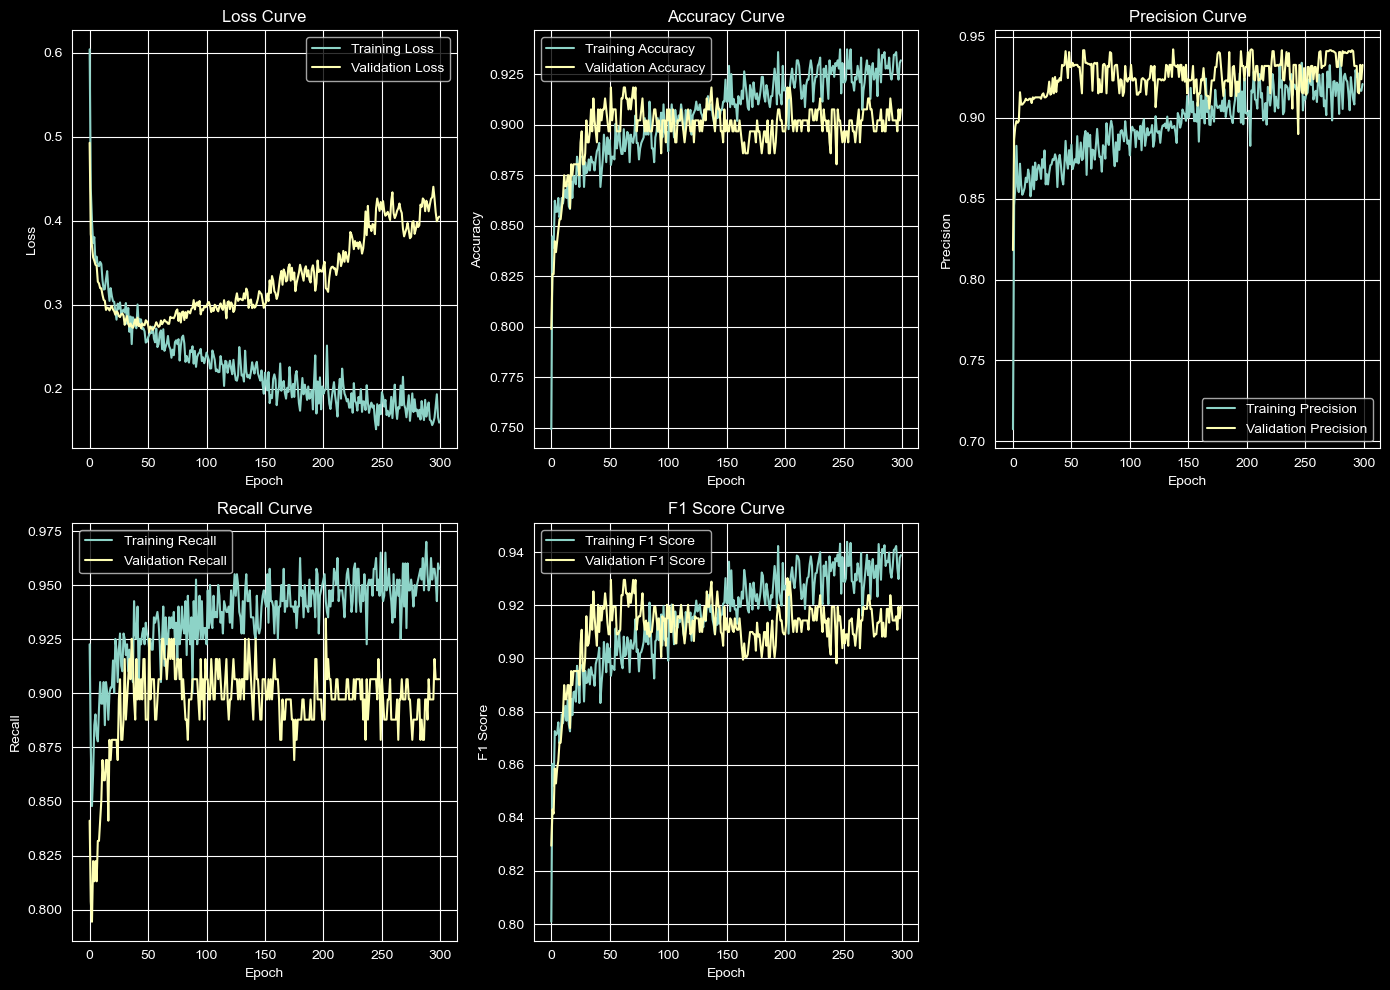

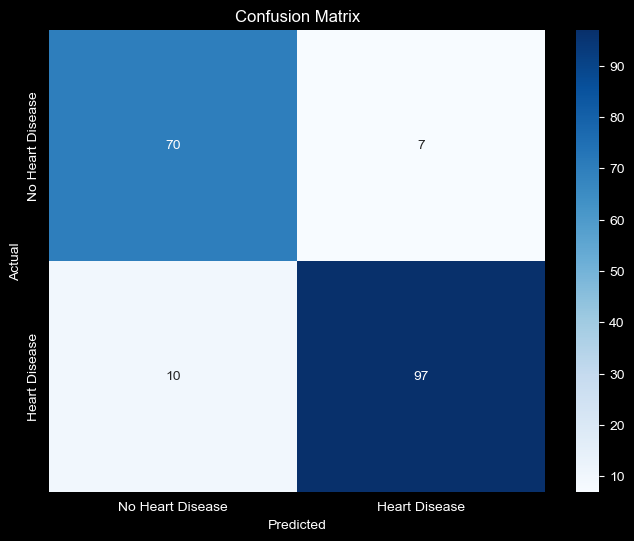

In [18]:
hidden_layers = best_params["hidden_layers"]
hidden_units = best_params["hidden_units"]
dropout_rate = best_params["dropout_rate"]
lr = best_params["lr"]
batch_size = best_params["batch_size"]

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model_mlp = MLP(X_train.shape[1], hidden_layers, hidden_units, dropout_rate)
criterion = nn.BCELoss()
optimizer = optim.Adam(model_mlp.parameters(), lr=lr)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []
train_f1s, val_f1s = [], []

for epoch in range(300):
    model_mlp.train()
    train_loss, train_correct, total_train = 0, 0, 0
    y_train_preds, y_train_targets = [], []
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model_mlp(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        preds = (outputs > 0.5).float()
        y_train_preds.extend(preds.numpy())
        y_train_targets.extend(targets.numpy())
        train_correct += (preds == targets).sum().item()
        total_train += targets.size(0)

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_correct / total_train)
    train_precisions.append(precision_score(y_train_targets, y_train_preds, zero_division=0))
    train_recalls.append(recall_score(y_train_targets, y_train_preds, zero_division=0))
    train_f1s.append(f1_score(y_train_targets, y_train_preds, zero_division=0))

    model_mlp.eval()
    val_loss, val_correct, total_val = 0, 0, 0
    y_val_preds, y_val_targets = [], []
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model_mlp(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            preds = (outputs > 0.5).float()
            y_val_preds.extend(preds.numpy())
            y_val_targets.extend(targets.numpy())
            val_correct += (preds == targets).sum().item()
            total_val += targets.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_correct / total_val)
    val_precisions.append(precision_score(y_val_targets, y_val_preds, zero_division=0))
    val_recalls.append(recall_score(y_val_targets, y_val_preds, zero_division=0))
    val_f1s.append(f1_score(y_val_targets, y_val_preds, zero_division=0))

 
plt.figure(figsize=(14, 10))

plt.subplot(2, 3, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(train_precisions, label='Training Precision')
plt.plot(val_precisions, label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision Curve')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(train_recalls, label='Training Recall')
plt.plot(val_recalls, label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall Curve')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(train_f1s, label='Training F1 Score')
plt.plot(val_f1s, label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score Curve')
plt.legend()

plt.tight_layout()
plt.show()

y_val_true = y_val.numpy().flatten()
y_val_pred = np.array(y_val_preds).flatten()

conf_matrix = confusion_matrix(y_val_true, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No Heart Disease', 'Heart Disease'], yticklabels=['No Heart Disease', 'Heart Disease'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

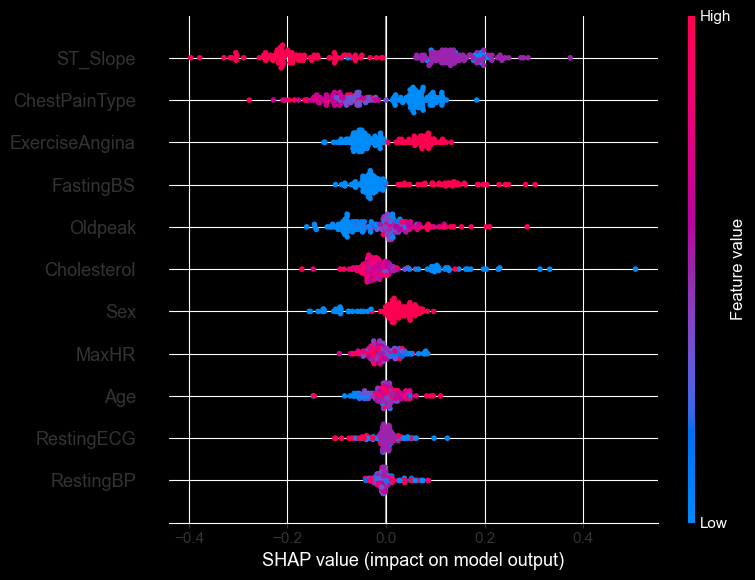

In [19]:
import shap
explainer = shap.DeepExplainer(model_mlp, torch.tensor(X_train.numpy()))
shap_values = explainer.shap_values(torch.tensor(X_val.numpy()))

if isinstance(shap_values, list):  
    shap_values_matrix = shap_values[0]
else:
    shap_values_matrix = shap_values 

shap.summary_plot(shap_values_matrix, X_val.numpy(), feature_names=data.columns[:-1])

## XGBClassifier

[I 2024-12-04 21:07:47,660] A new study created in memory with name: no-name-42f72aed-d04e-48a1-a78f-ad4b3320991a
[21:07:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[I 2024-12-04 21:07:47,691] Trial 0 finished with value: -0.8041237071952386 and parameters: {'n_estimators': 90, 'max_depth': 6, 'learning_rate': 0.004319685063174062, 'subsample': 0.9362026360063633, 'colsample_bytree': 0.7956868536140148, 'gamma': 2.304098035105712, 'min_child_weight': 5}. Best is trial 0 with value: -0.8041237071952386.
[21:07:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[I 2024-12-04 21:07:47,725] Trial 1 finished with value: -0.4099616842530204 and parameters: {'n_estimators': 143, 'max_depth': 8

Best parameters: {'n_estimators': 318, 'max_depth': 3, 'learning_rate': 0.35056134827192553, 'subsample': 0.6902279776195361, 'colsample_bytree': 0.9471321768374308, 'gamma': 1.5579011722031026, 'min_child_weight': 3}
Validation Metrics:
Accuracy: 0.8696
Precision: 0.9278
Recall: 0.8411
F1-Score: 0.8824


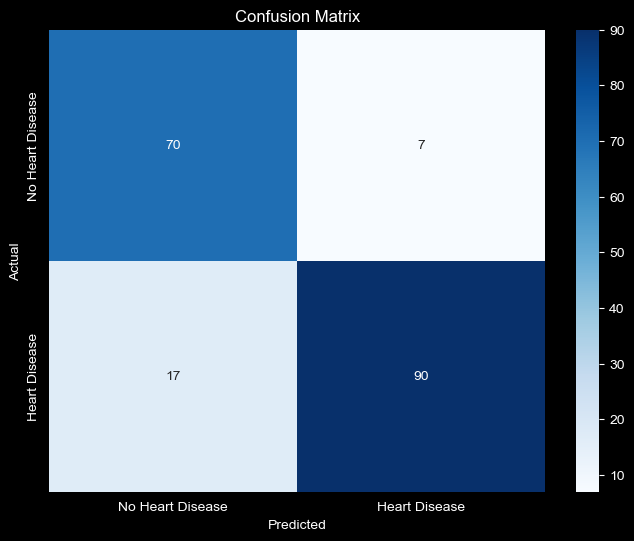

In [21]:
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

def objective(trial):
     
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
    }
    
 
    model = XGBClassifier(**params, use_label_encoder=False, eval_metric="logloss", random_state=42)
    model.fit(X_train, y_train)

    y_val_pred = model.predict(X_val)
    
    conf_matrix = confusion_matrix(y_val, y_val_pred)
    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]

    accuracy = (TP + TN) / (TP + 2 * FP + TN + 1e-6)
    
    return -accuracy 

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

best_params = study.best_trial.params
print("Best parameters:", best_params)

model_xgb = XGBClassifier(**best_params, use_label_encoder=False, eval_metric="logloss", random_state=42)
model_xgb.fit(X_train, y_train)

y_val_pred = model_xgb.predict(X_val)

conf_matrix = confusion_matrix(y_val, y_val_pred)
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred, zero_division=0)
recall = recall_score(y_val, y_val_pred, zero_division=0)
f1 = f1_score(y_val, y_val_pred, zero_division=0)

print("Validation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No Heart Disease', 'Heart Disease'], yticklabels=['No Heart Disease', 'Heart Disease'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

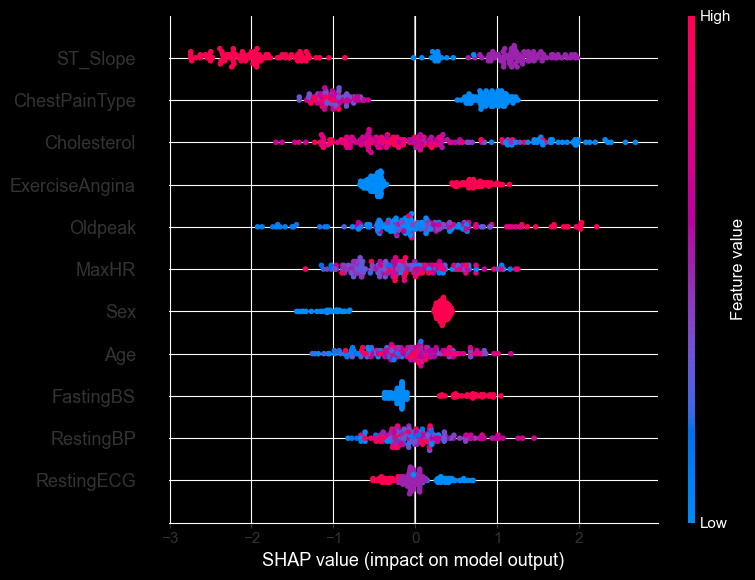

In [22]:
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_val)

shap.summary_plot(shap_values, X_val, feature_names=data.columns[:-1])

## RandomForestClassifier

[I 2024-12-04 21:07:52,016] A new study created in memory with name: no-name-16154e05-8772-4a8e-9082-86f1d5b018e1
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[I 2024-12-04 21:07:52,104] Trial 0 finished with value: -0.8797814159574786 and parameters: {'n_estimators': 119, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: -0.8797814159574786.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[I 2024-12-04 21:07:52,223] Trial 1 finished with value: -0.8791208742905446 and parameters: {'n_estimators': 118, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: -0.8797814159574786.
A column-vector y was passed when a 1d array was expected. Please change the sh

Best parameters: {'n_estimators': 341, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': True}
Validation Metrics:
Accuracy: 0.9022
Precision: 0.9238
Recall: 0.9065
F1-Score: 0.9151


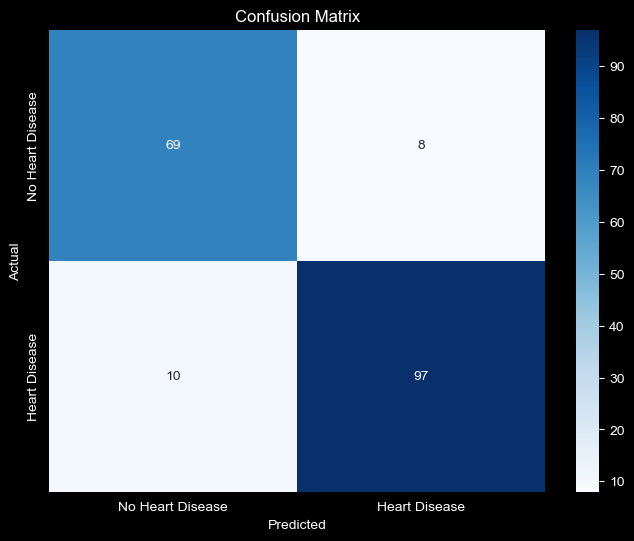

In [23]:
import optuna
from sklearn.ensemble import RandomForestClassifier


def objective(trial):

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),  
        "max_depth": trial.suggest_int("max_depth", 3, 20),          
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10), 
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),   
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),  
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False])  
    }


    model = RandomForestClassifier(random_state=42, **params)
    model.fit(X_train, y_train)

    y_val_pred = model.predict(X_val)
    
    conf_matrix = confusion_matrix(y_val, y_val_pred)
    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]

    accuracy = (TP + TN) / (TP + 2 * FP + TN + 1e-6)
    
    return -accuracy 

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

best_params = study.best_trial.params
print("Best parameters:", best_params)

best_model_rf = RandomForestClassifier(random_state=42, **best_params)
best_model_rf.fit(X_train, y_train)

y_val_pred = best_model_rf.predict(X_val)

conf_matrix = confusion_matrix(y_val, y_val_pred)
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred, zero_division=0)
recall = recall_score(y_val, y_val_pred, zero_division=0)
f1 = f1_score(y_val, y_val_pred, zero_division=0)

print("Validation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No Heart Disease', 'Heart Disease'], yticklabels=['No Heart Disease', 'Heart Disease'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

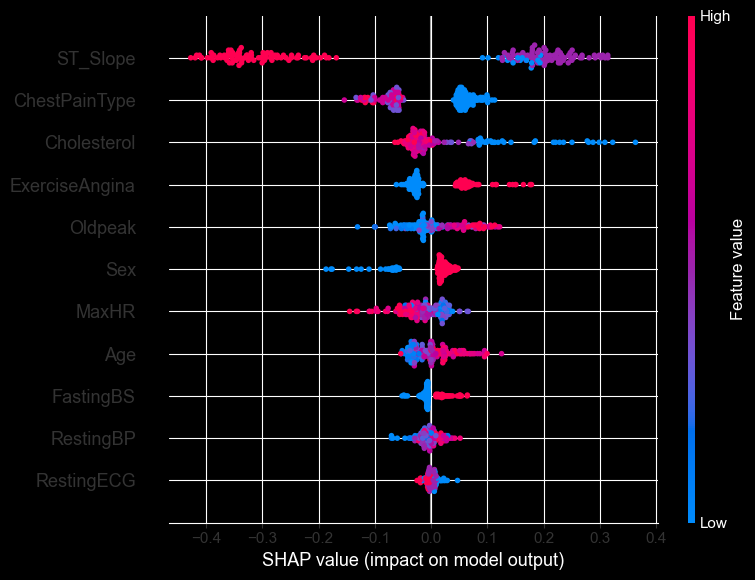

In [24]:
explainer = shap.TreeExplainer(best_model_rf)

X_val_ndarray = np.array(X_val)  
shap_values = explainer.shap_values(X_val_ndarray)

shap.summary_plot(shap_values[1], X_val_ndarray, feature_names=data.columns[:-1])